In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv('train.csv')
df_copy = df

In [5]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Missing Values:

In [6]:
df.isnull().sum()[df.isnull().sum() > 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [7]:
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [8]:
df_cat = df.select_dtypes(include = 'object')
df_num = df.select_dtypes(exclude = 'object')

df.update(df[df_cat.columns].fillna('na'))
df.update(df[df_num.columns].fillna(0))

# Correlation:

In [9]:
#for categorical variables:

def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

Correlation function from: https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

In [10]:
df.MSSubClass = df.MSSubClass.apply(str)
df_cat = df.select_dtypes(include = 'object')

for i in df_cat.columns:
    data = df[i]
    if (correlation_ratio(data, df.SalePrice) > 0):
        print(i,':', correlation_ratio(data, df.SalePrice))

MSSubClass : 0.49630229983102675
MSZoning : 0.3279629299879021
Street : 0.041035535500049534
Alley : 0.14285497856663895
LotShape : 0.2763615521925143
LandContour : 0.16060537183203935
Utilities : 0.014314296147248773
LotConfig : 0.1449805660703004
LandSlope : 0.051784414298815404
Neighborhood : 0.7386304832658636
Condition1 : 0.1806395304453634
Condition2 : 0.09949452606283138
BldgType : 0.18583333094140705
HouseStyle : 0.2937901075671953
RoofStyle : 0.2402012284068327
RoofMatl : 0.17723747640844897
Exterior1st : 0.3908620257099605
Exterior2nd : 0.39221149922589343
MasVnrType : 0.43453711043076526
ExterQual : 0.6909325420958304
ExterCond : 0.15368025465904525
Foundation : 0.5063283534727419
BsmtQual : 0.6819045227010956
BsmtCond : 0.22670642511670291
BsmtExposure : 0.38665272781048293
BsmtFinType1 : 0.45914094751281065
BsmtFinType2 : 0.1740516691435969
Heating : 0.12015463131446785
HeatingQC : 0.442154368790011
CentralAir : 0.251328163840155
Electrical : 0.24431835801832044
KitchenQua

In [11]:
#for numerical variables

corr = df.corr()
corr_list = corr['SalePrice'].sort_values(ascending = False)
corr_list

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
MasVnrArea       0.472614
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.349876
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
GarageYrBlt      0.261366
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

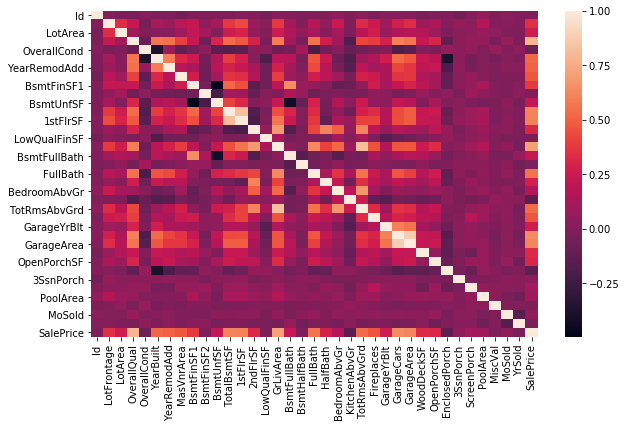

In [12]:
plt.figure(figsize = (10,6))
sns.heatmap(corr)

In [13]:
df.drop(['Id', 'Street', 'Utilities'], axis = 1, inplace = True)
df_cat = df.select_dtypes(include = 'object')
df_num = df.select_dtypes(exclude = 'object')

# EDA:

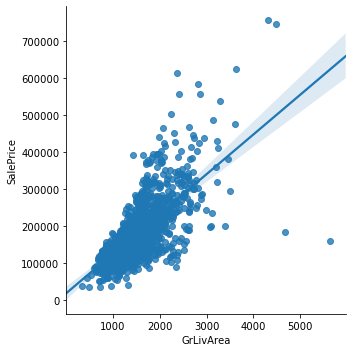

In [14]:
sns.lmplot(data = df, x = 'GrLivArea', y = 'SalePrice')

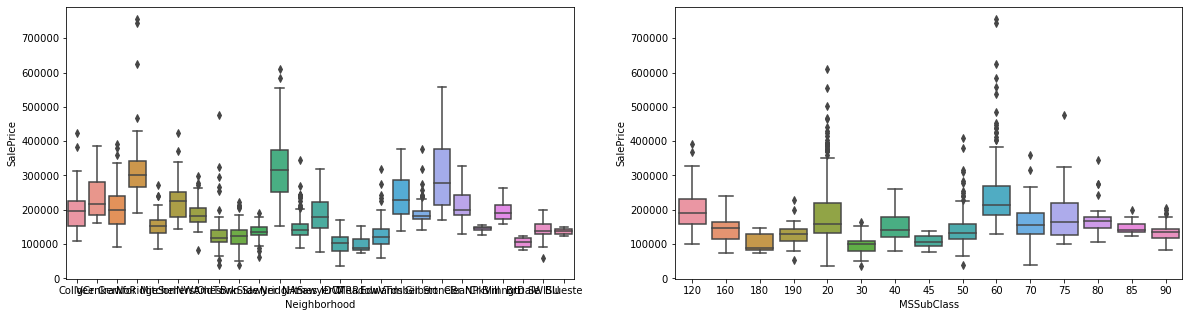

In [15]:
fig, ax = plt.subplots(1,2, figsize = (20,5))
sns.boxplot(data = df, x = 'Neighborhood', y = 'SalePrice', ax = ax[0])
sns.boxplot(data = df, x = 'MSSubClass', y = 'SalePrice', ax = ax[1])

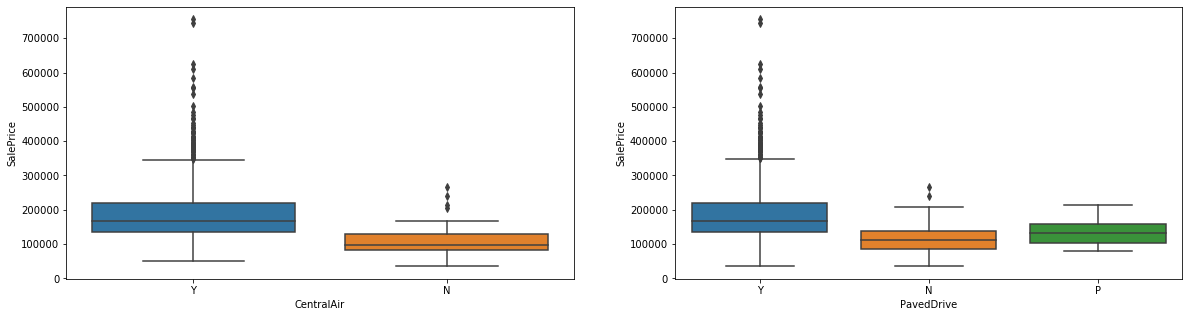

In [16]:
fig, ax = plt.subplots(1,2, figsize = (20,5))
sns.boxplot(data = df, x = 'CentralAir', y = 'SalePrice', ax = ax[0])
sns.boxplot(data = df, x = 'PavedDrive',y = 'SalePrice', ax = ax[1])

# Cross Validation function:

In [17]:
def crossval(X, y, reg):
    result = []
    for i in range(10):
        result.append(cross_val_score(reg, X, y).mean())
    return np.mean(result)

# Transforming categorical features:

In [18]:
df = pd.get_dummies(df)

# Random Forest Regressor:

In [19]:
X = df.drop('SalePrice', axis = 1)
y = df.SalePrice
reg = RandomForestRegressor()
crossval(X, y,reg)

0.8375453887005225

# Outliers:

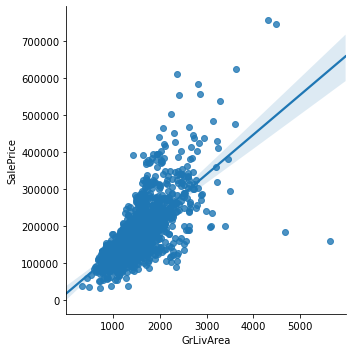

In [20]:
#outliers
sns.lmplot(data = df, x = 'GrLivArea', y = 'SalePrice')

In [21]:
df[df.GrLivArea > 4000]['SalePrice']

523     184750
691     755000
1182    745000
1298    160000
Name: SalePrice, dtype: int64

In [22]:
df.drop(1298, inplace = True)
df.drop(523, inplace = True)

# RFR after outliers treatment:

In [23]:
X = df.drop('SalePrice', axis = 1)
y = df.SalePrice
reg = RandomForestRegressor()
crossval(X, y, reg)

0.8666862128553762

# Normalization:

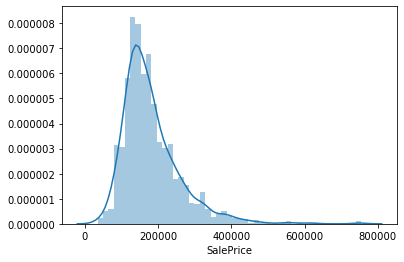

In [24]:
sns.distplot(df.SalePrice)

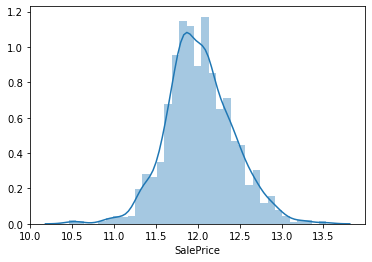

In [25]:
for i in df_num.columns:
    df[i] = np.log1p(df[i])
    df.reset_index(drop=True, inplace=True)
sns.distplot(df.SalePrice)

# XGB Regressor

## learning_rate tuning:

In [33]:
score = []
X_treino, X_teste, Y_treino, Y_teste = train_test_split(X, y, test_size = 0.33, random_state = 10)
for i in np.arange(0.01, 0.5, 0.02):
    xgb = XGBRegressor(learning_rate = i)
    xgb.fit(X_treino, Y_treino, verbose=False)
    print(xgb.score(X_teste,Y_teste), i)

-101.8682272876998 0.01
-0.9791130666988925 0.03
0.8296704781131142 0.049999999999999996
0.8774872327151797 0.06999999999999999
0.8817208833931371 0.08999999999999998
0.884443999469217 0.10999999999999997
0.8877000263329602 0.12999999999999998
0.8897587393175418 0.15
0.88508178125569 0.16999999999999998
0.8864933325490194 0.18999999999999997
0.8792670816678012 0.20999999999999996
0.8708915661768355 0.22999999999999998
0.8791138409669421 0.24999999999999997
0.868280735669864 0.26999999999999996
0.8626780078645225 0.29
0.8643576070206003 0.30999999999999994
0.867615533830606 0.32999999999999996
0.8648893004676712 0.35
0.8740918114630406 0.36999999999999994
0.8612397249383099 0.38999999999999996
0.8559143833759417 0.4099999999999999
0.8441535268279295 0.42999999999999994
0.8376770980974151 0.44999999999999996
0.8604078221779566 0.4699999999999999
0.8556495522205837 0.48999999999999994


## Validation:

In [34]:
result = []
for i in np.arange(1,10):
    X_treino, X_teste, Y_treino, Y_teste = train_test_split(X, y, test_size = 0.33, random_state = i)
    xgb = XGBRegressor(learning_rate = 0.15)
    xgb.fit(X_treino, Y_treino, verbose=False)
    score = xgb.score(X_teste,Y_teste)
    result.append(score)
np.mean(result)

0.8821218432965875

# df_test transformation and submit:

In [28]:
df_test = pd.read_csv('test.csv')

df_copy['test'] = 0
df_test['test'] = 1
feat = pd.concat([df_copy, df_test])



#df_num.drop('SalePrice', axis = 1, inplace = True)
for i in df_num.columns:
    feat[i] = np.log1p(feat[i])
    feat.reset_index(drop=True, inplace=True)
feat.drop(['Id', 'Street', 'Utilities'], axis = 1, inplace = True)

feat.MSSubClass = feat.MSSubClass.apply(str)
feat.update(feat[df_cat.columns].fillna('na'))
feat.update(feat[df_num.columns].fillna(0))
feat['LotFrontage'] = feat.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
feat = pd.get_dummies(feat)

In [29]:
test = feat[feat.test == 1]
train = feat[feat.test == 0]

test.drop('SalePrice', axis = 1, inplace = True)

In [30]:
xgb = XGBRegressor(learning_rate = 0.08)
X = train.drop('SalePrice', axis = 1)
y = train.SalePrice
xgb.fit(X, y, verbose=False)
resp = xgb.predict(test)

In [31]:
resp = np.expm1(resp)

submit = pd.Series(resp, index=df_test['Id'], name='SalePrice')
submit.to_csv("model.csv", header=True)